## 4. Investigate fragmented replay content by summing placefield

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cupy as cp
import numpy as np
import numpy.ma as ma
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting.v0 as ss

from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.spikesorting.v0.curation_figurl import CurationFigurl,CurationFigurlSelection
from spyglass.spikesorting.v0.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection,IntervalLinearizedPosition

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.ripple_detection import removeDataBeforeTrial1
from spyglass.shijiegu.helpers import interpolate_to_new_time
from spyglass.shijiegu.placefield import place_field,placefield_to_peak1dloc
from spyglass.shijiegu.Analysis_SGU import DecodeResultsLinear
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)
warnings.filterwarnings('ignore')

[2025-04-16 14:02:24,269][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-04-16 14:02:24,438][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [3]:
from spyglass.shijiegu.helpers import interval_union
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,ExtendedRippleTimes,RippleTimesWithDecode
from spyglass.shijiegu.load import load_run_sessions
from spyglass.shijiegu.singleUnit import (do_mountainSort,electrode_unit,RippleTime2FiringRate,findWaveForms,RippleTime2Index,
                            )
from spyglass.shijiegu.fragmented import (permute_frag_cont,find_spike_count_ratio,
                            get_nwb_units,find_firing_cross_correlation,classify_cells)
from spyglass.shijiegu.placefield import cell_by_arm

In [4]:
from spyglass.shijiegu.singleUnit import (session_unit,RippleTime2FiringRate,
                                          find_spikes,xcorr)

In [5]:
outputFolder='/cumulus/shijie/recording_pilot/eliot/FragmentedReplay/'
isExist = os.path.exists(outputFolder)
if not isExist:
    os.makedirs(outputFolder)

In [278]:
nwb_copy_file_name = "lewis20240109_.nwb"
nwb_copy_file_name = "eliot20221022_.nwb"

In [279]:
run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221022_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221022_ 2         02_Seq2Session pos 1 valid ti
eliot20221022_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221022_ 4         04_Seq2Session pos 3 valid ti
eliot20221022_ 5         05_Seq2Sleep3  pos 4 valid ti
eliot20221022_ 6         06_Seq2Session pos 5 valid ti
eliot20221022_ 7         07_Seq2Sleep4  pos 6 valid ti
eliot20221022_ 8         08_Seq2Session pos 7 valid ti
eliot20221022_ 9         09_Seq2Sleep5  pos 8 valid ti
eliot20221022_ 10        10_Seq2Session pos 9 valid ti
eliot20221022_ 11        11_Seq2Sleep6  pos 10 valid t
 (Total: 11)



In [280]:
epoch_num = 3
session_name = run_session_names[epoch_num]
pos_name = pos_session_names[epoch_num]
print(session_name)

08_Seq2Session4


In [281]:
# load spikes
nwb_units_all, sort_group_ids_with_good_cell = session_unit(nwb_copy_file_name,session_name,curation_id = 1)

# load ripple
try:
    ripple_times = pd.DataFrame((RippleTimesWithDecode & 
                             {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))
except:
    ripple_times = pd.read_pickle((RippleTimesWithDecode & 
                             {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))
    

# load place field

In [282]:
#nwb_units_all

In [225]:
"""
cell_list = []
for e in sort_group_ids_with_good_cell:
    for u in nwb_units_all[e].index:
        cell_list.append((e, u))
        
placefields = {}
mobility_spike_counts = {}
all_spike_counts = {}
peak_frs = {}
for row_ind in range(len(cell_list)):
    print(row_ind)
    e = cell_list[row_ind][0]
    u = cell_list[row_ind][1]
    placefield, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(nwb_copy_file_name, session_name, pos_name, e, u)
    placefields[(e,u)] = placefield
    peak_frs[(e,u)] = peak_fr
    mobility_spike_counts[(e,u)] = mobility_spike_count
    all_spike_counts[(e,u)] = all_spike_count
"""

'\ncell_list = []\nfor e in sort_group_ids_with_good_cell:\n    for u in nwb_units_all[e].index:\n        cell_list.append((e, u))\n        \nplacefields = {}\nmobility_spike_counts = {}\nall_spike_counts = {}\npeak_frs = {}\nfor row_ind in range(len(cell_list)):\n    print(row_ind)\n    e = cell_list[row_ind][0]\n    u = cell_list[row_ind][1]\n    placefield, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(nwb_copy_file_name, session_name, pos_name, e, u)\n    placefields[(e,u)] = placefield\n    peak_frs[(e,u)] = peak_fr\n    mobility_spike_counts[(e,u)] = mobility_spike_count\n    all_spike_counts[(e,u)] = all_spike_count\n'

### Place fields of exclusive fragmented cells

In [291]:
count_ratio, firing_rate_F, firing_rate_C, unit_name = find_spike_count_ratio(nwb_units_all,ripple_times)

In [294]:
cont_ind = np.array(count_ratio) < 0.01
cont_ind = np.argwhere(cont_ind).ravel()
cont_units = [unit_name[i] for i in cont_ind]
cont_count_ratio = [count_ratio[i] for i in cont_ind]

frag_ind = np.array(count_ratio) > 2
frag_ind = np.argwhere(frag_ind).ravel()
frag_units = [unit_name[i] for i in frag_ind]
frag_count_ratio = [count_ratio[i] for i in frag_ind]

In [295]:
frag_units

[(5, 6),
 (5, 7),
 (5, 9),
 (13, 10),
 (13, 14),
 (14, 17),
 (16, 6),
 (17, 9),
 (26, 10),
 (26, 18),
 (30, 3)]

In [296]:
cell_list = frag_units
count_ratio = frag_count_ratio
        
cell_list_ = []  
placefields = {}
placefields_im = {}
mobility_spike_counts = {}
all_spike_counts = {}
peak_frs = {}
count_ratios = {}

for row_ind in range(len(cell_list)):
    print(row_ind)
    e = cell_list[row_ind][0]
    u = cell_list[row_ind][1]
    
    
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,e,curation_id=1)
    print(e,u)
    
    placefield_im, _, _1, _2, _3, _4 = place_field(
        nwb_copy_file_name, session_name, pos_name, e, u,
        curation_id = 1, nwb_units = nwb_units,
        immobility = True,
        normalize = False)
    
    placefield, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(
        nwb_copy_file_name, session_name, pos_name, e, u,
        curation_id = 1, nwb_units = nwb_units,
        immobility = False,
        normalize = True)
    if mobility_spike_count < 5:
        continue
        
    cell_list_.append((e,u))
    count_ratios[(e,u)] = count_ratio[row_ind]
    
    placefields[(e,u)] = placefield
    placefields_im[(e,u)] = placefield_im
    peak_frs[(e,u)] = peak_fr
    mobility_spike_counts[(e,u)] = mobility_spike_count
    all_spike_counts[(e,u)] = all_spike_count

cell_list = cell_list_

0
5 6
spike num: 340
spike num: 340
1
5 7
spike num: 775
spike num: 775
2
5 9
spike num: 171
spike num: 171
3
13 10
spike num: 296
spike num: 296
4
13 14
spike num: 95
spike num: 95
5
14 17
spike num: 294
spike num: 294
6
16 6
spike num: 1628
spike num: 1628
7
17 9
spike num: 406
spike num: 406
8
26 10
spike num: 1536
spike num: 1536
9
26 18
spike num: 496
spike num: 496
10
30 3
spike num: 419
spike num: 419


In [297]:
#count_ratios

### 1. Place field

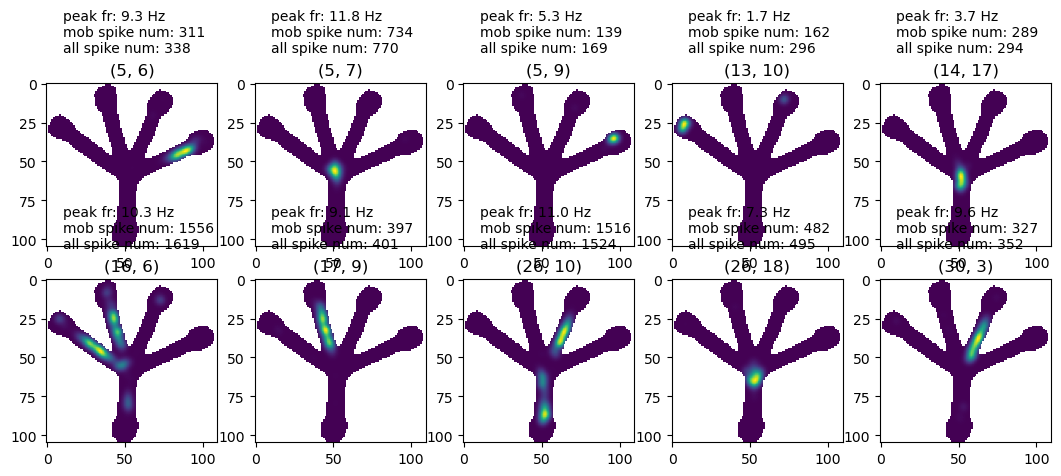

In [298]:
# low firing rate
row_num = int(np.ceil(len(cell_list)/5))
fig, axes = plt.subplots(row_num,5, figsize = (13,7 * row_num/3), squeeze = True)

ind = 0
for p in np.arange(len(cell_list)):
    
    (e,u) = cell_list[p]
    axes[np.unravel_index(ind, axes.shape)].imshow(placefields[(e,u)])
    axes[np.unravel_index(ind, axes.shape)].set_title(str((e,u)))
    axes[np.unravel_index(ind, axes.shape)].text(10,-20,"peak fr: "+str(round(peak_frs[(e,u)],1))+" Hz \n" + 
                                                 "mob spike num: "+str(mobility_spike_counts[e,u]) + "\n" +
                                                 "all spike num: "+str(all_spike_counts[e,u]))
    ind = ind + 1

for p in np.arange(ind, 10):
    axes[np.unravel_index(p, axes.shape)].set_axis_off()

### 2. immobility place field

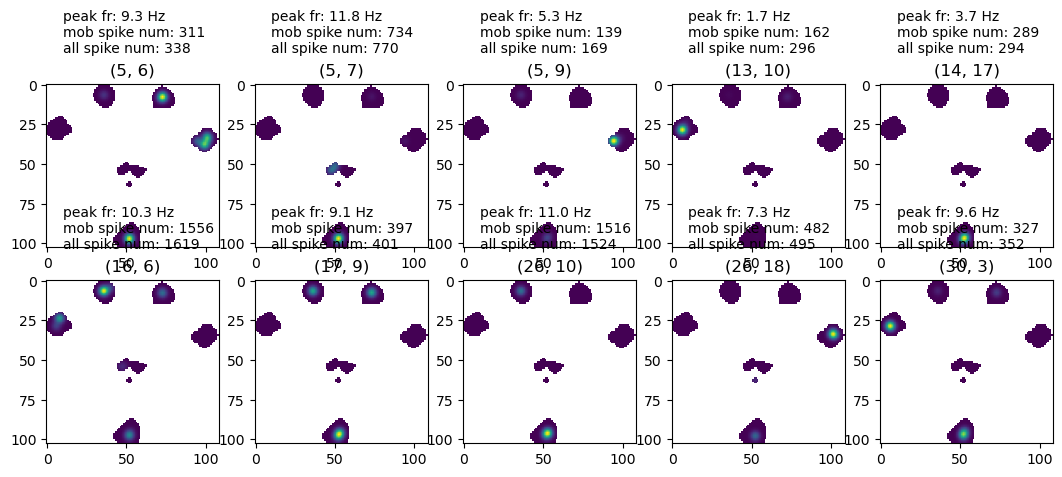

In [299]:
# low firing rate
row_num = int(np.ceil(len(cell_list)/5))
fig, axes = plt.subplots(row_num,5, figsize = (13,7 * row_num/3), squeeze = True)

ind = 0
for p in np.arange(len(cell_list)):
    
    (e,u) = cell_list[p]
    axes[np.unravel_index(ind, axes.shape)].imshow(placefields_im[(e,u)])
    axes[np.unravel_index(ind, axes.shape)].set_title(str((e,u)))
    axes[np.unravel_index(ind, axes.shape)].text(10,-20,"peak fr: "+str(round(peak_frs[(e,u)],1))+" Hz \n" + 
                                                 "mob spike num: "+str(mobility_spike_counts[e,u]) + "\n" +
                                                 "all spike num: "+str(all_spike_counts[e,u]))
    ind = ind + 1

for p in np.arange(ind, 10):
    axes[np.unravel_index(p, axes.shape)].set_axis_off()

In [204]:
pfr = [peak_frs[key] for key in peak_frs.keys()]    

In [205]:
pfr_index = np.argsort(pfr)

In [206]:
pfr_index[0]

1

IndexError: index 5 is out of bounds for axis 0 with size 5

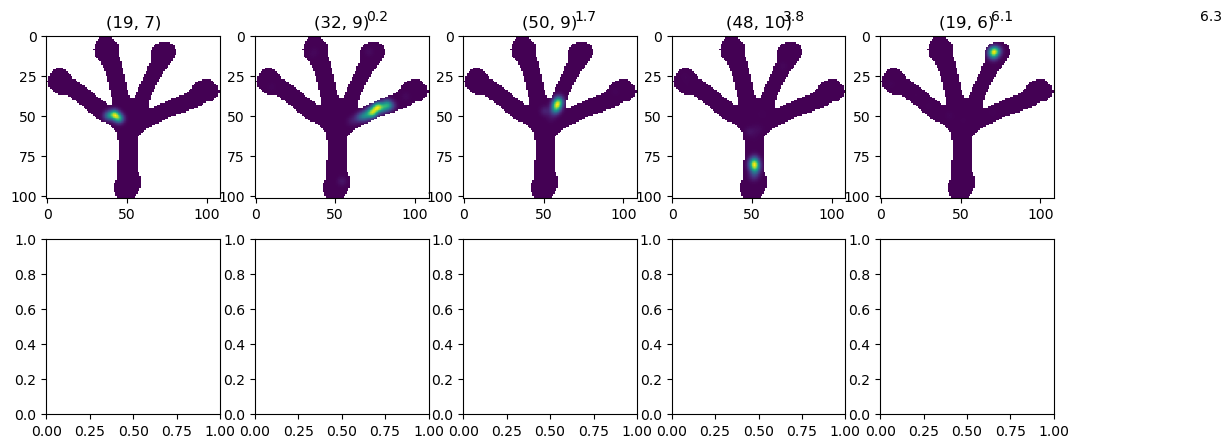

In [207]:
# low firing rate
fig, axes = plt.subplots(2,5, figsize = (13,5), squeeze = True)

ind = 0
for p in np.arange(10):
    
    (e,u) = cell_list[pfr_index[p]]
    axes[np.unravel_index(ind, axes.shape)].imshow(placefields[(e,u)])
    axes[np.unravel_index(ind, axes.shape)].set_title(str((e,u)))
    axes[np.unravel_index(ind, axes.shape)].text(200,-10,round(peak_frs[(e,u)],1))
    ind = ind + 1

In [ ]:
# high firing rate
fig, axes = plt.subplots(2,5, figsize = (13,5), squeeze = True)

ind = 0
for p in np.arange(10):
    
    (e,u) = cell_list[pfr_index[0+p]]
    axes[np.unravel_index(ind, axes.shape)].imshow(placefields[(e,u)])
    axes[np.unravel_index(ind, axes.shape)].set_title(str((e,u)))
    axes[np.unravel_index(ind, axes.shape)].text(200,-10,round(peak_frs[(e,u)],1))
    ind = ind + 1

Text(200, 25, '17.2')

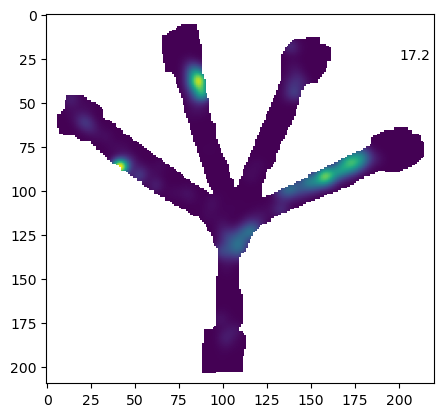

In [107]:
e = 14
u = 9
# (14,9), (13,7), (16,6)
placefield, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(nwb_copy_file_name, session_name, pos_name, e, u)
plt.imshow(placefield)
plt.text(200,25,np.round(peak_fr,1))

Text(200, 25, '35.4')

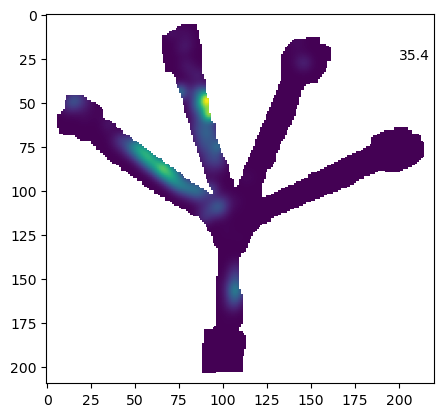

In [63]:
e = 16
u = 6

plt.imshow(placefields[(e,u)])
plt.text(200,25,np.round(peak_frs[(e,u)],1))

In [124]:
#peak normalize placefield
normalized_placefields = {}
for row_ind in range(len(cell_list)):
    print(row_ind)
    e = cell_list[row_ind][0]
    u = cell_list[row_ind][1]
    normalized_placefields[(e,u)] = placefields[(e,u)]/np.nanmax(placefields[(e,u)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [117]:
count_ratio, firing_rate_F, firing_rate_C = find_spike_count_ratio(nwb_units_all,ripple_times)

In [118]:
cells_frag, cells_cont = classify_cells(firing_rate_F, firing_rate_C)

electrode 0 unit 3
during fragmented replay:  7.304430676138095 31.0
during cont replay:  3.709264109928835 84.0
electrode 0 unit 4
during fragmented replay:  0.23562679600445469 1.0
during cont replay:  0.04415790607058137 1.0
electrode 0 unit 6
during fragmented replay:  2.8275215520534562 12.0
during cont replay:  1.9871057731761617 45.0
electrode 0 unit 7
during fragmented replay:  3.5344019400668203 15.0
during cont replay:  0.7506844031998833 17.0
electrode 0 unit 8
during fragmented replay:  1.1781339800222734 5.0
during cont replay:  0.1324737182117441 3.0
electrode 2 unit 3
during fragmented replay:  2.356267960044547 10.0
during cont replay:  1.1481055578351156 26.0
electrode 5 unit 2
during fragmented replay:  0.0 0.0
during cont replay:  0.9273160274822088 21.0
electrode 5 unit 5
during fragmented replay:  2.120641164040092 9.0
during cont replay:  0.30910534249406957 7.0
electrode 5 unit 6
during fragmented replay:  0.23562679600445469 1.0
during cont replay:  0.0 0.0
elec

In [119]:
def sum_place_field(normalized_placefields,activate_cell_cont):
    cell_num = 0
    placefields_intvl = []
    for cell in activate_cell_cont:
        (e,u) = cell
        tmp = normalized_placefields[(e,u)]
        if np.sum(~np.isnan(tmp)) != 0:
            placefields_intvl.append(normalized_placefields[(e,u)])
            cell_num = cell_num + 1
    placefields_intvl = np.array(placefields_intvl)
    placefields_intvl_sum = np.sum(placefields_intvl, axis = 0)
    return placefields_intvl_sum, cell_num
    

In [120]:
def sum_place_field_by_weight(normalized_placefields,activate_cell_cont,weights):
    cell_num = 0
    valid_index = []
    for cell_ind in range(len(activate_cell_cont)):
        cell = activate_cell_cont[cell_ind]
        tmp = normalized_placefields[tuple(cell)]
        if np.sum(~np.isnan(tmp)) != 0:
            valid_index.append(cell_ind)
            cell_num = cell_num + 1
        else:
            weights[cell_ind] = 0

    weights = weights/np.sum(weights)
    placefields_intvl_sum = np.sum(
        np.array(
            [normalized_placefields[tuple(activate_cell_cont[ind])] * weights[ind] for ind in valid_index]
        ),
        axis = 0)
    return placefields_intvl_sum, cell_num

In [122]:
cell_non_frag = list(set(cell_list)-set(cells_frag))

array([31.24993667, 15.62496834, 15.62496834, 15.62496834])

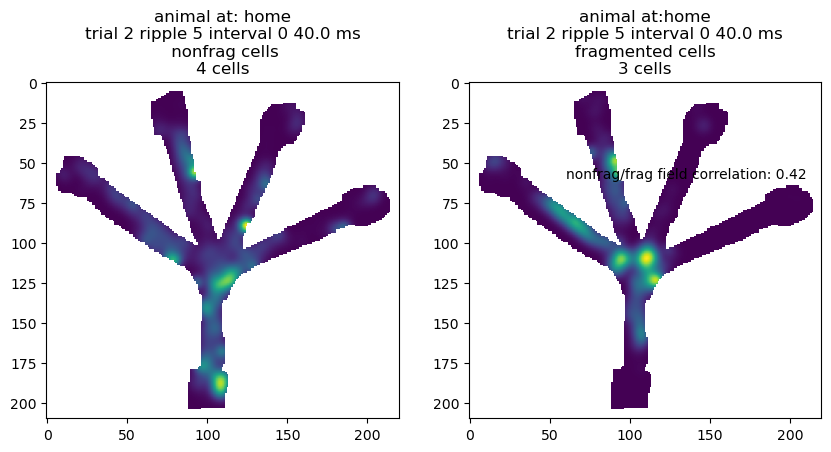

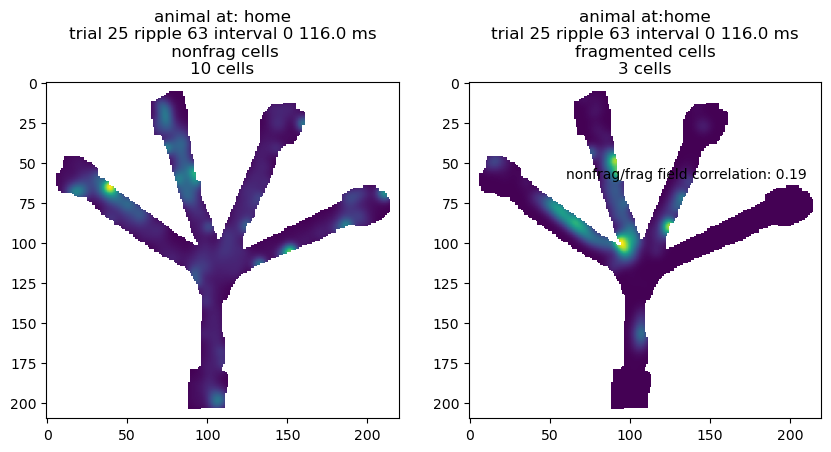

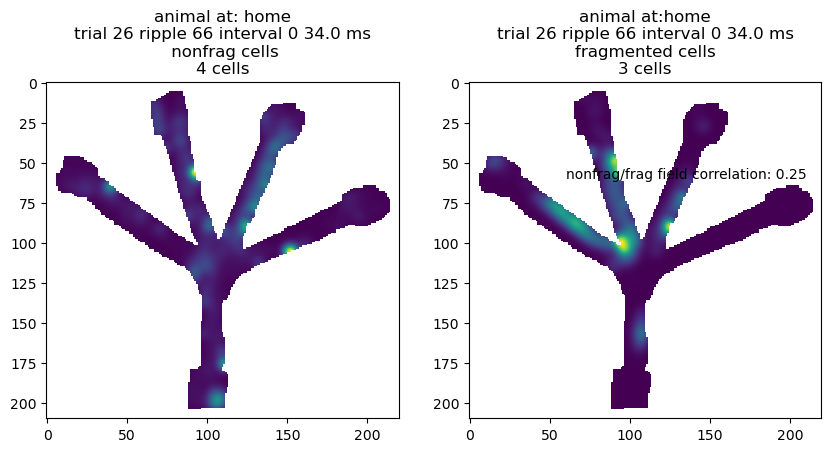

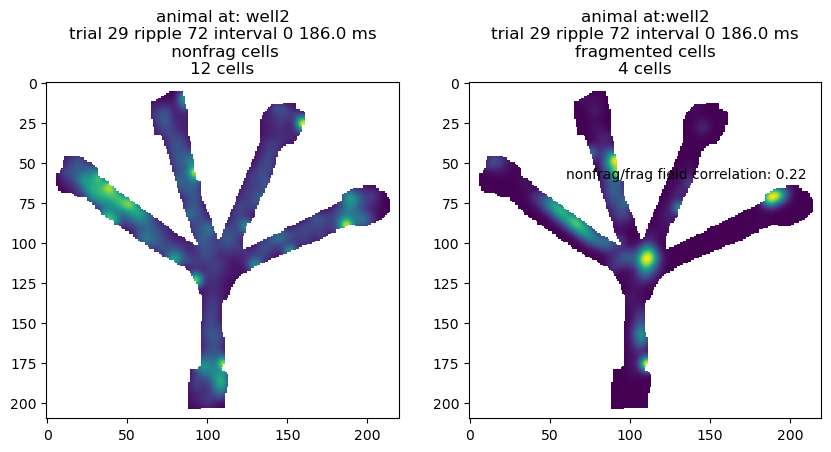

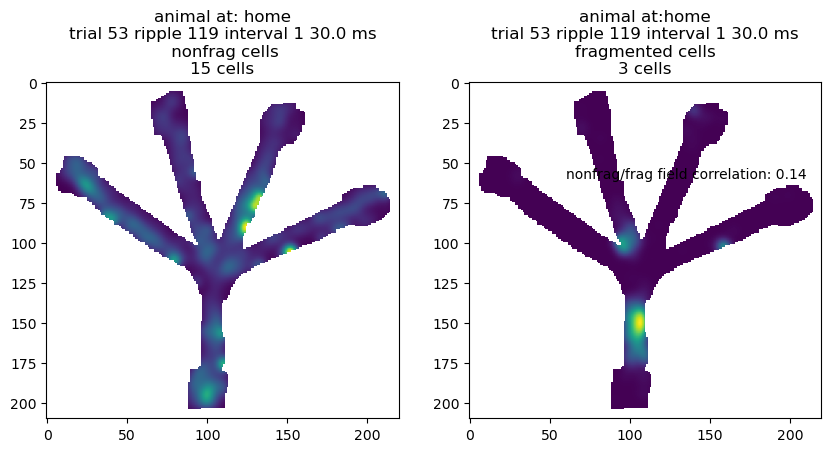

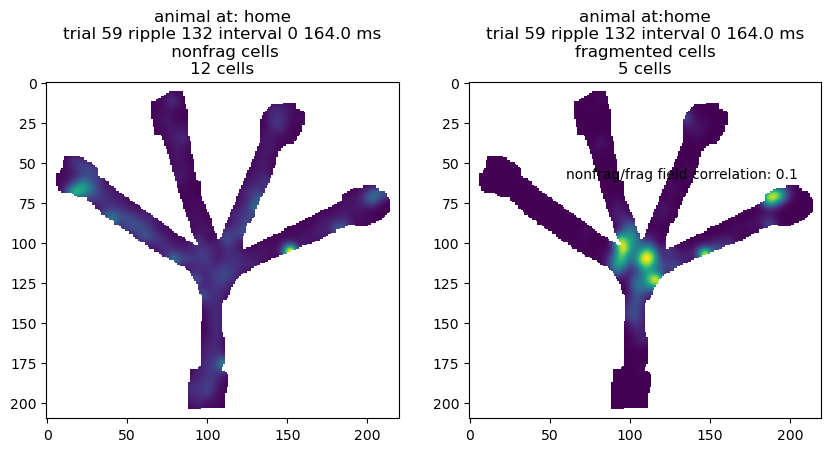

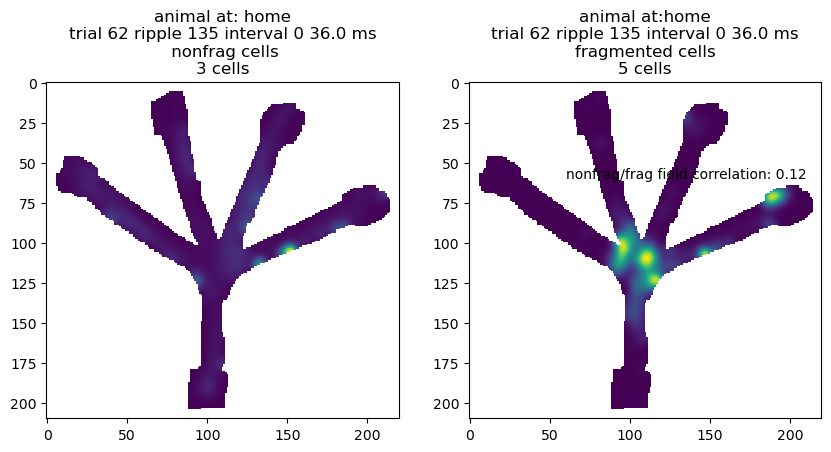

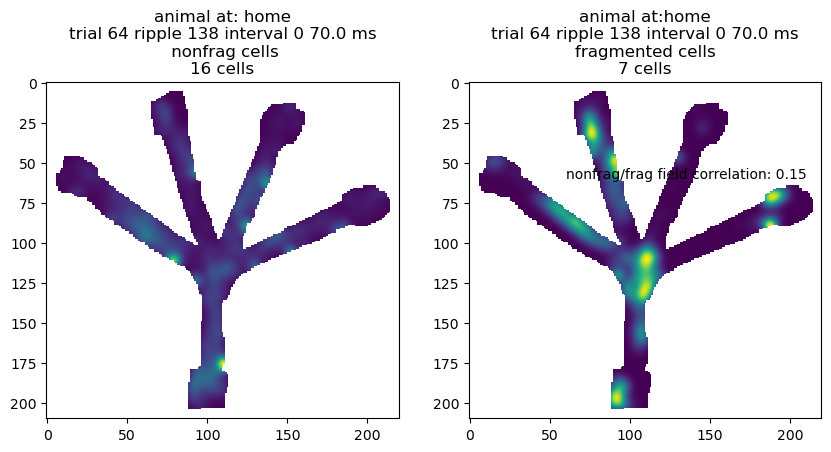

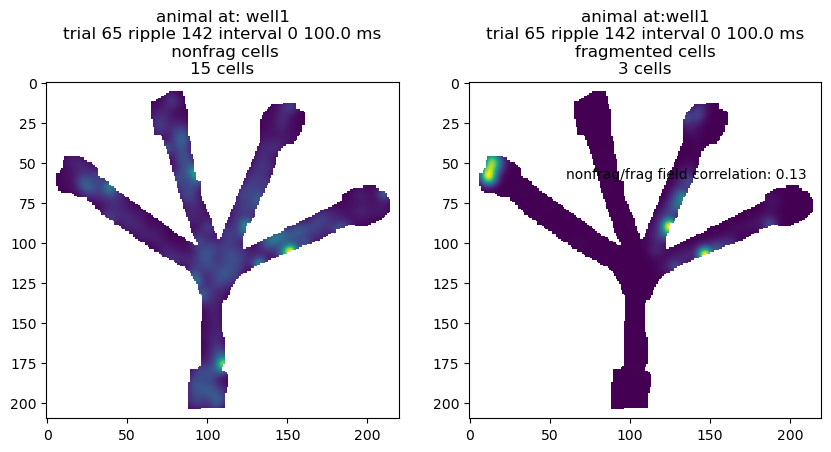

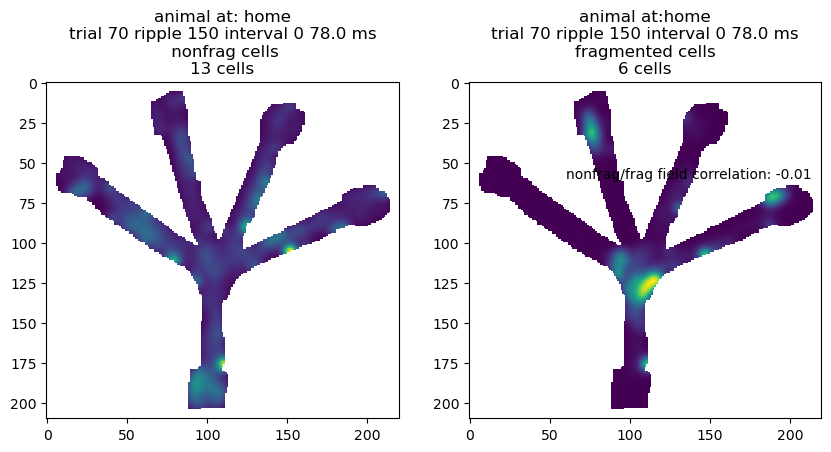

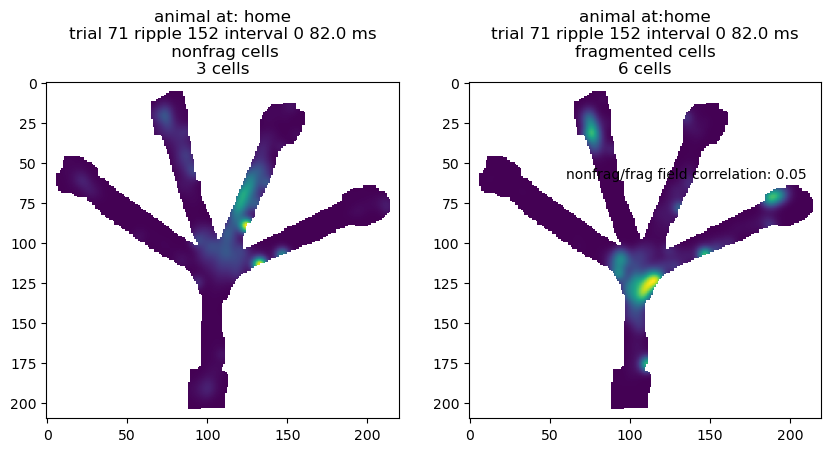

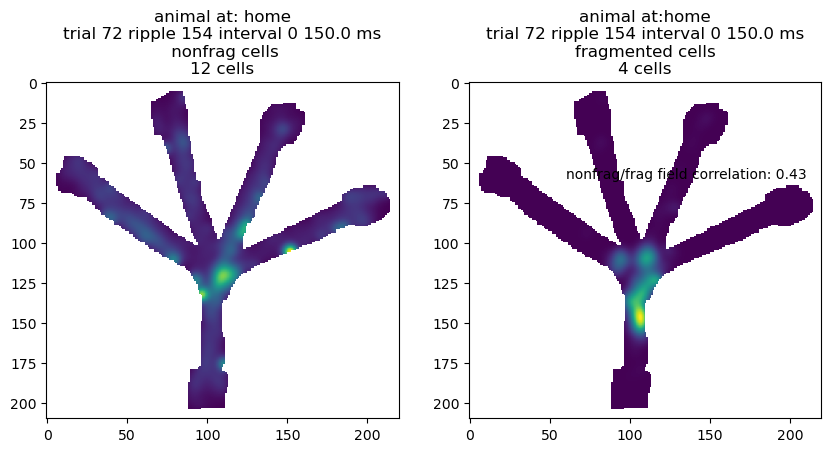

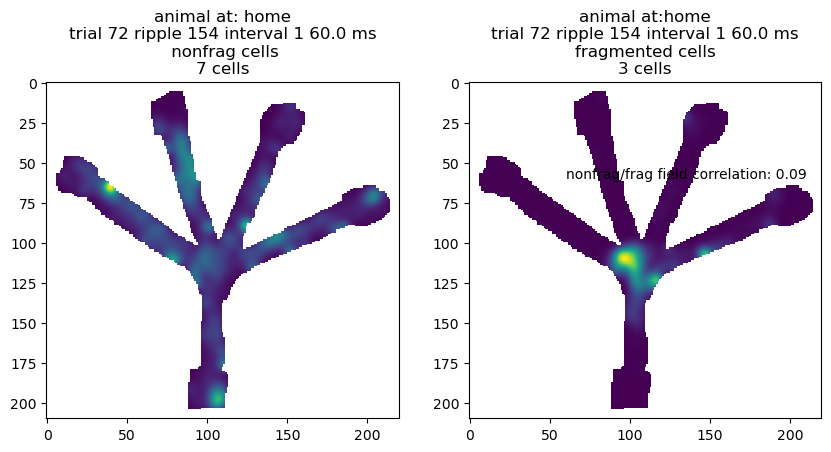

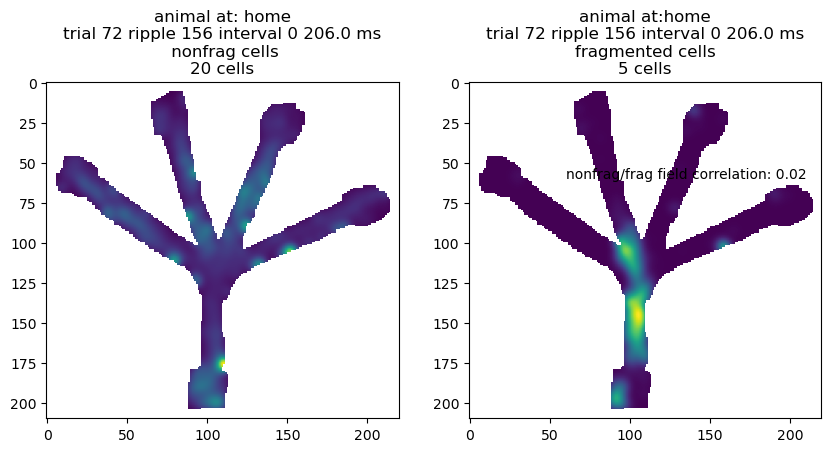

In [125]:
placefields_intvl_sum_cont_all=[]
placefields_intvl_sum_frag_all=[]

for ripple_ID in ripple_times.index:
    intvls = ripple_times.loc[ripple_ID].frag_intvl	
    trial = ripple_times.loc[ripple_ID].trial_number
    location = ripple_times.loc[ripple_ID].animal_location
    if len(intvls) == 0:
        continue
    
    for intvl_ind in range(intvls.shape[0]):
        intvl = intvls[intvl_ind]
        
        duration = str(round(float(np.diff(intvl))*1000,1)) + ' ms'
        
        firing_cont = find_spikes(nwb_units_all,cell_non_frag,intvl).ravel()
        activate_cell_cont = np.array(cell_non_frag)[firing_cont > 0]
        weights = firing_cont[firing_cont>0]
        if len(activate_cell_cont) == 0:
            continue
        placefields_intvl_sum_cont, cell_num_cont = sum_place_field_by_weight(normalized_placefields,activate_cell_cont,weights)

        firing_frag = find_spikes(nwb_units_all,cells_frag,intvl).ravel()
        activate_cell_frag = np.array(cells_frag)[firing_frag > 0]
        if len(activate_cell_frag) > 0:
            placefields_intvl_sum_frag, cell_num_frag = sum_place_field(normalized_placefields,activate_cell_frag)

        if cell_num_cont > 2 and cell_num_frag > 2:
            placefields_intvl_sum_cont_all.append(placefields_intvl_sum_cont)
            placefields_intvl_sum_frag_all.append(placefields_intvl_sum_frag)
            
            valid_ind = ~np.isnan(placefields_intvl_sum_cont)
            field_cont = placefields_intvl_sum_cont[valid_ind]
            field_frag = placefields_intvl_sum_frag[valid_ind]
            corr = np.corrcoef(field_cont, field_frag)[0,1]
            
            fig, axes = plt.subplots(1,2,figsize = (10,5),sharex = 1,squeeze = False)
            axes[0,0].imshow(placefields_intvl_sum_cont)
            axes[0,0].set_title('animal at: '+location+
                '\ntrial '+str(trial)+' ripple '+str(ripple_ID)+' interval '+ str(intvl_ind)+' '+duration+
                                        '\n nonfrag cells\n'+str(cell_num_cont)+' cells')
            axes[0,1].text(60,60,'nonfrag/frag field correlation: '+str(round(corr,2)))
            
            
            axes[0,1].imshow(placefields_intvl_sum_frag)
            axes[0,1].set_title('animal at:'+location+
                    '\ntrial '+str(trial)+' ripple '+str(ripple_ID)+' interval '+ str(intvl_ind)+' '+duration+
                                        '\nfragmented cells\n'+str(cell_num_frag)+' cells')

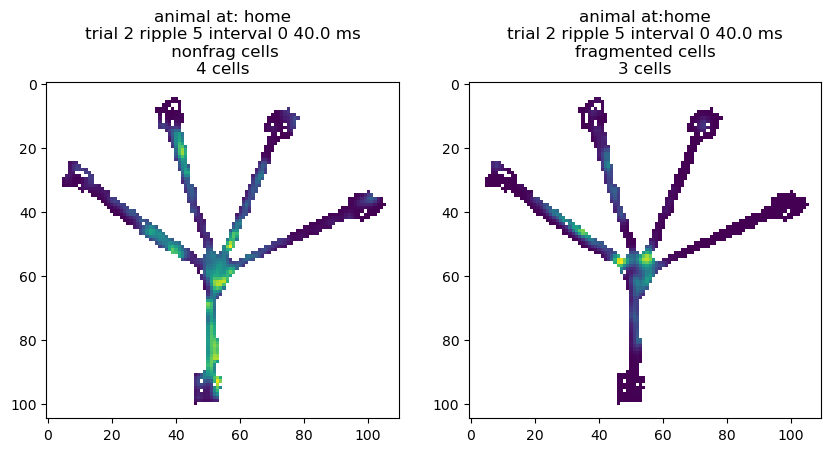

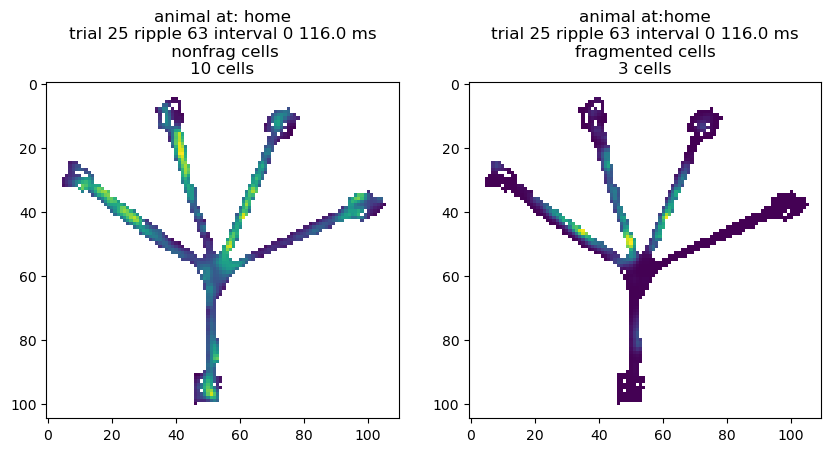

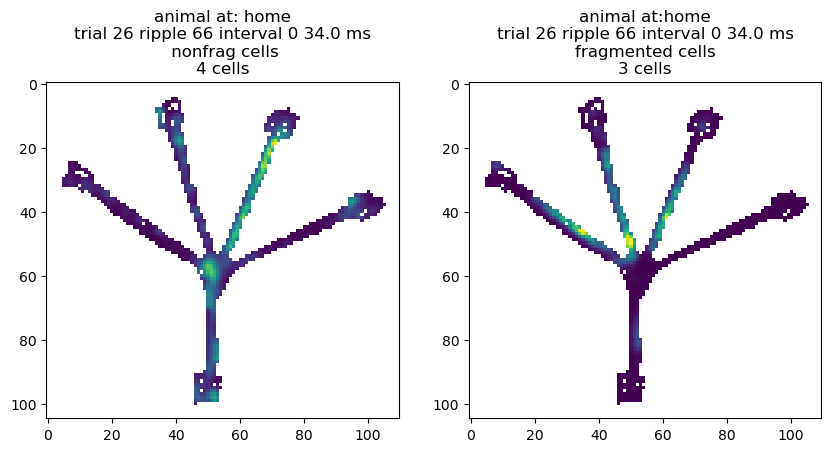

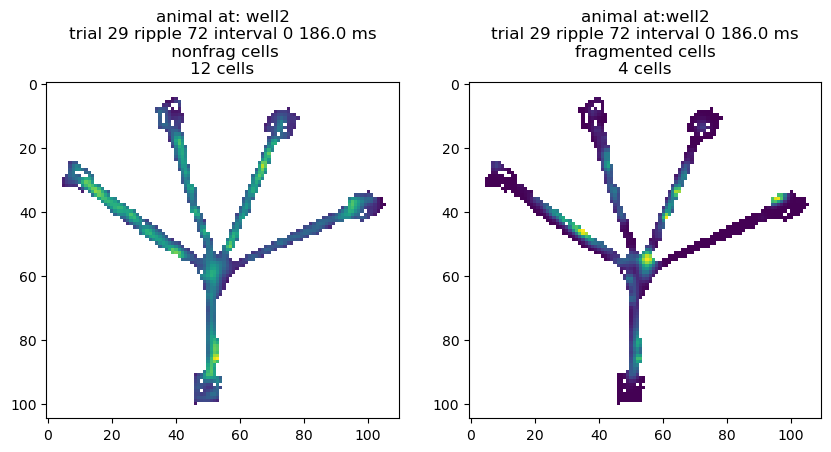

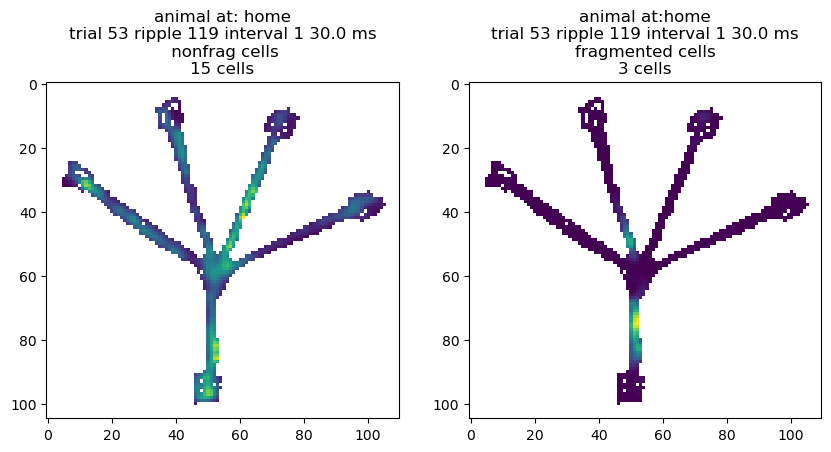

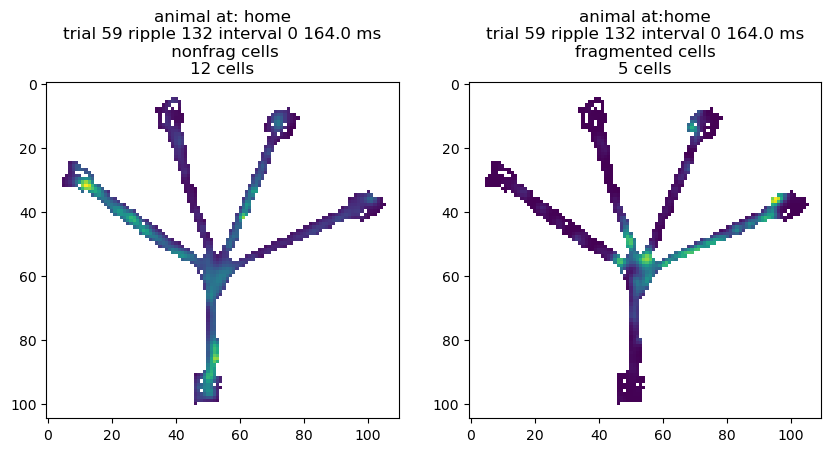

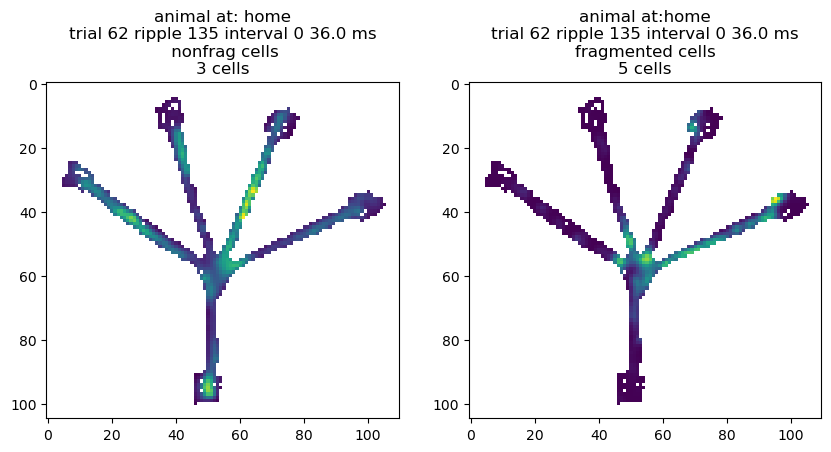

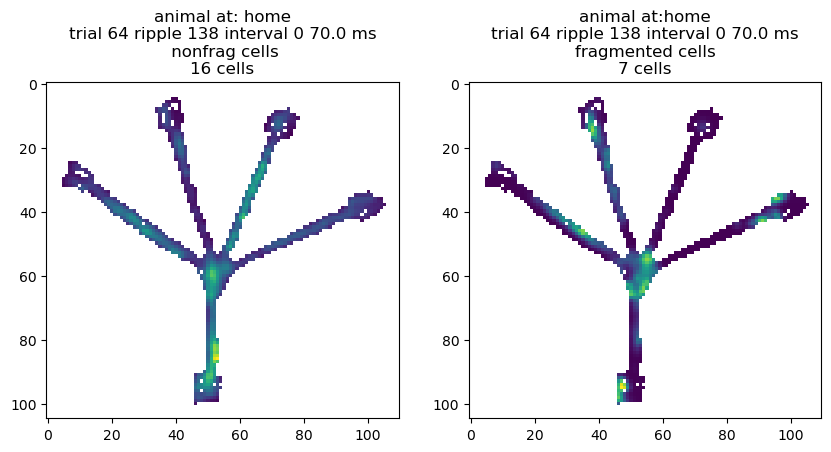

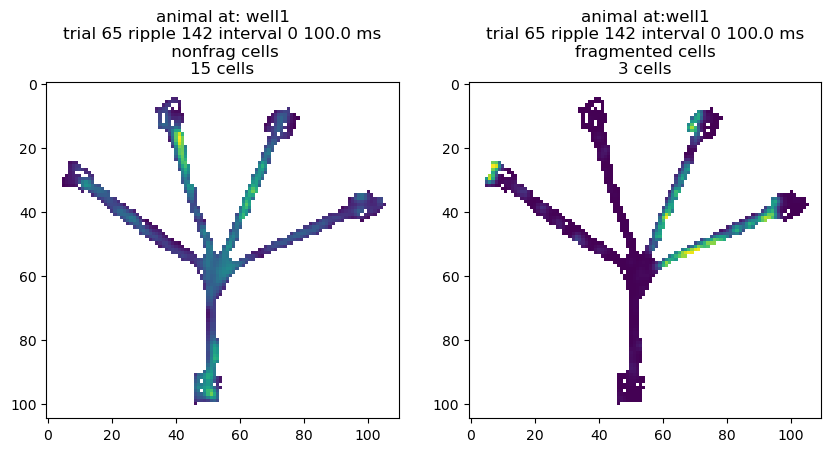

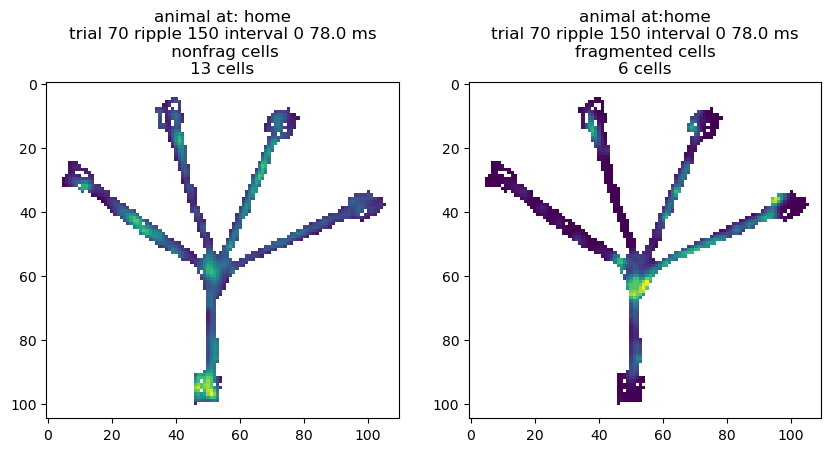

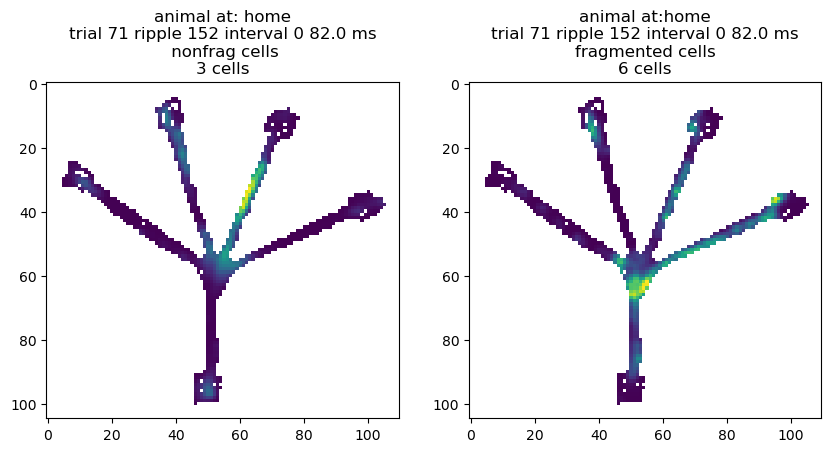

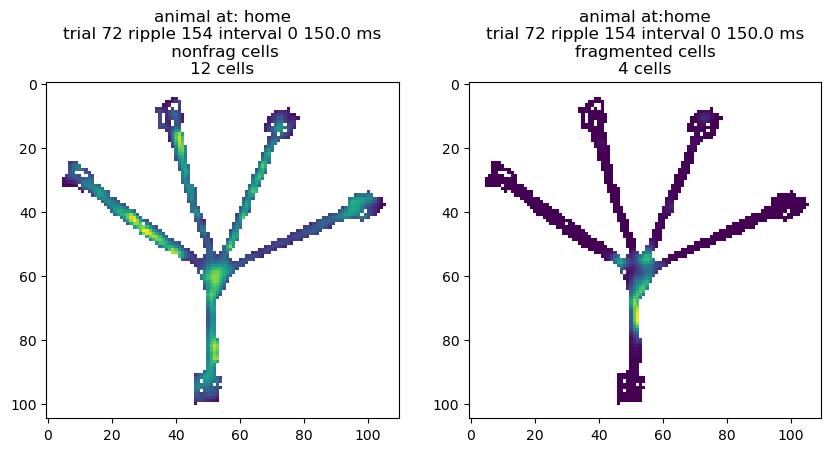

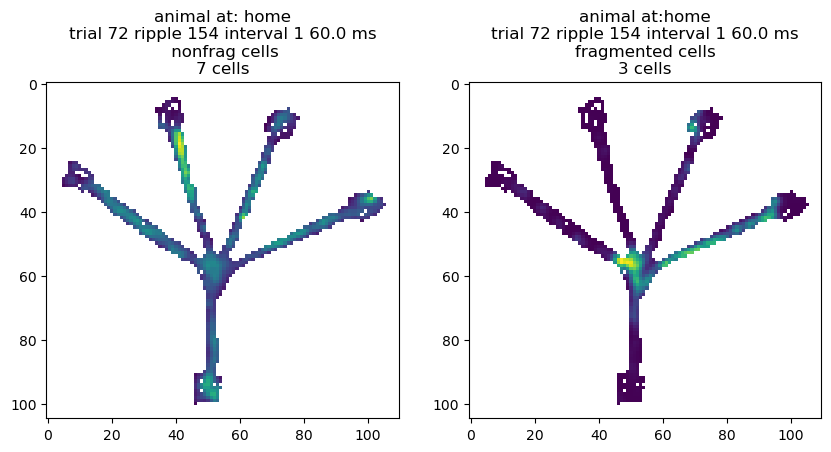

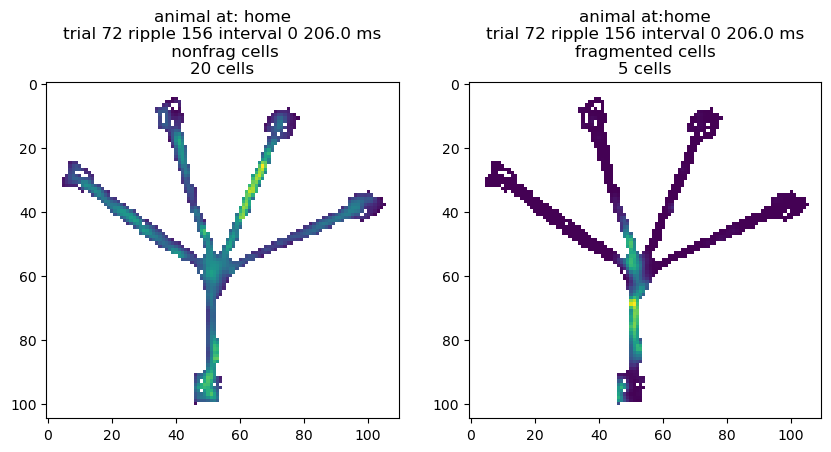

In [149]:
for ripple_ID in ripple_times.index:
    intvls = ripple_times.loc[ripple_ID].frag_intvl	
    trial = ripple_times.loc[ripple_ID].trial_number
    location = ripple_times.loc[ripple_ID].animal_location
    if len(intvls) == 0:
        continue
    
    for intvl_ind in range(intvls.shape[0]):
        intvl = intvls[intvl_ind]
        
        duration = str(round(float(np.diff(intvl))*1000,1)) + ' ms'
        
        firing_cont = find_spikes(nwb_units_all,cell_non_frag,intvl).ravel()
        activate_cell_cont = np.array(cell_non_frag)[firing_cont > 0]
        weights = firing_cont[firing_cont>0]
        if len(activate_cell_cont) == 0:
            continue
        placefields_intvl_sum_cont, cell_num_cont = sum_place_field(normalized_placefields,activate_cell_cont)

        firing_frag = find_spikes(nwb_units_all,cells_frag,intvl).ravel()
        activate_cell_frag = np.array(cells_frag)[firing_frag > 0]
        if len(activate_cell_frag) > 0:
            placefields_intvl_sum_frag, cell_num_frag = sum_place_field(normalized_placefields,activate_cell_frag)

        if cell_num_cont > 2 and cell_num_frag > 2:
            fig, axes = plt.subplots(1,2,figsize = (10,5),sharex = 1,squeeze = False)
            axes[0,0].imshow(placefields_intvl_sum_cont)
            axes[0,0].set_title('animal at: '+location+
                '\ntrial '+str(trial)+' ripple '+str(ripple_ID)+' interval '+ str(intvl_ind)+' '+duration+
                                        '\n nonfrag cells\n'+str(cell_num_cont)+' cells')
            
            
            axes[0,1].imshow(placefields_intvl_sum_frag)
            axes[0,1].set_title('animal at:'+location+
                    '\ntrial '+str(trial)+' ripple '+str(ripple_ID)+' interval '+ str(intvl_ind)+' '+duration+
                                        '\nfragmented cells\n'+str(cell_num_frag)+' cells')

In [126]:
place_corr = []

for i in range(len(placefields_intvl_sum_cont_all)):
    print(i)
    field_cont = placefields_intvl_sum_cont_all[i]
    field_frag = placefields_intvl_sum_frag_all[i]

    # mean subtraction
    #field_cont = field_cont - np.nanmean(field_cont)
    #field_frag = field_frag - np.nanmean(field_frag)

    valid_ind = ~np.isnan(field_cont)
    field_cont = field_cont[valid_ind]
    field_frag = field_frag[valid_ind]

    #field_cont = field_cont > np.nanmedian(field_cont) #/(np.max(field_cont) - np.min(field_cont))
    #field_frag = field_frag > np.nanmedian(field_frag) #/(np.max(field_frag) - np.min(field_frag))

    #field_cont = field_cont/np.linalg.norm(field_cont)
    #field_frag = field_frag/np.linalg.norm(field_frag)
    
    place_corr.append(np.corrcoef(field_cont, field_frag)[0,1])
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [127]:
# permute
placefields_intvl_sum_all = placefields_intvl_sum_cont_all + placefields_intvl_sum_frag_all

place_corr_B =[]

for b in range(1000):
    place_corr_b = []
    
    for i in range(len(placefields_intvl_sum_cont_all)):
        (ii,jj) = np.random.choice(np.arange(len(placefields_intvl_sum_all)),replace = False, size = 2)
        
        field_cont = placefields_intvl_sum_all[ii]
        field_frag = placefields_intvl_sum_all[jj]
    
        # mean subtraction
        #field_cont = field_cont - np.nanmean(field_cont)
        #field_frag = field_frag - np.nanmean(field_frag)
    
        valid_ind = ~np.isnan(field_cont)
        field_cont = field_cont[valid_ind]
        field_frag = field_frag[valid_ind]
    
        #field_cont = field_cont > np.nanmedian(field_cont) #/(np.max(field_cont) - np.min(field_cont))
        #field_frag = field_frag > np.nanmedian(field_frag) #/(np.max(field_frag) - np.min(field_frag))
    
        #field_cont = field_cont/np.linalg.norm(field_cont)
        #field_frag = field_frag/np.linalg.norm(field_frag)
        
        place_corr_b.append(np.corrcoef(field_cont, field_frag)[0,1])
    place_corr_B.append(place_corr_b)

Text(0.5, 1.0, 'field summation correlation coef')

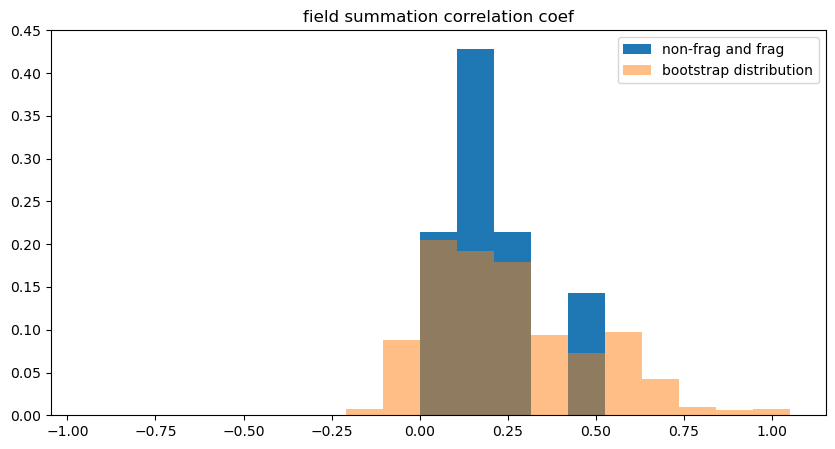

In [128]:
fig, axes = plt.subplots(1,1,figsize = (10,5),sharex = 1,squeeze = True)
data, axis = np.histogram(place_corr,np.linspace(-1,1,20),
                          weights = np.ones(len(place_corr))/len(place_corr),
                          )
axes.bar(axis[1:],data,width = axis[1]-axis[0],label = 'non-frag and frag')

place_corr_b = np.concatenate(place_corr_B)
data_b, axis = np.histogram(place_corr_b,np.linspace(-1,1,20),weights = np.ones(len(place_corr_b))/len(place_corr_b))
axes.bar(axis[1:],data_b,width = axis[1]-axis[0],alpha = 0.5,label = 'bootstrap distribution')

axes.legend()
axes.set_title('field summation correlation coef')